In [1]:
pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os, itertools, random
import tensorflow
from tensorflow import keras
from IPython.display import SVG
from keras.utils import plot_model, model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical,np_utils
from keras.layers import (Conv1D, Input, Activation, BatchNormalization, Multiply,
                          LeakyReLU, Add, Flatten, Dense)
from keras.models import Model
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention

In [3]:
def load_data(file_path):
    df_train = pd.read_excel(file_path)
    train_x = df_train.drop('Label', axis=1)
    train_y = df_train['Label']
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.15, random_state=0)
    return X_train, y_train, X_test, y_test


def preprocess_data(X_train, y_train, X_test, y_test):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_x.fit_transform(X_train)
    X_test = scaler_x.transform(X_test)
    X_train = X_train.reshape((X_train.shape[0], -1, 8)).astype(np.float32)
    #y_train = y_train.values.reshape((y_train.shape[0], 1)).astype(np.float32)
    X_test = X_test.reshape((X_test.shape[0], -1, 8)).astype(np.float32)
    #y_test = y_test.values.reshape((y_test.shape[0], 1)).astype(np.float32)
    # One-hot encode labels
    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)
    num_classes = np.max(y_train) + 1
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    return X_train, y_train, X_test, y_test



def create_model(sequence_length, nb_features, n_filters=32, filter_width=2, dilation_rates=[1, 2, 3]):
    history_seq = Input(shape=(sequence_length, nb_features))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation="relu")(x)

        # filter
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width,
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        x_f = LeakyReLU()(x_f)
        x_f = BatchNormalization()(x_f)

        # gate
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width,
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        x_ga = SeqSelfAttention(
                           kernel_regularizer=keras.regularizers.l2(1e-4),
                           bias_regularizer=keras.regularizers.l1(1e-4),
                           attention_regularizer_weight=1e-4)(x_g)
        # combine filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_ga)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation="relu")(z)

        # residual connection
        x = Add()([x, z])

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs
    out = Activation('relu')(Add()(skips))

    out = Flatten()(out)

    # Final dense layer
    out = Dense(4, activation="softmax")(out)

    model = Model(history_seq, out)
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model

def train_model(X_train, y_train, batch_size, epochs, verbose):
    history = model.fit(X_train, y_train,
                   steps_per_epoch=len(X_train)//batch_size,
                   epochs=epochs,
                   verbose=verbose,validation_split=0.15, callbacks=[checkpoint, early_stopping])
    return history


In [4]:
#First, import and view the data
df_train = pd.read_excel(r'/content/sample_data/All_data_1.xls')
df_train.head()

,PZ_Press,PZ_Level,RX_MeanCoolTemp,PZ_temperature,RC1_PumpSpeed,RC1_PumpFlow,RC2PumpSpeed,RC2PumpFlow,Label
0,1.511510e+07,6.000183,577.231119,591.449690,100.000000,8801.400000,100.000000,8801.400000,0
1,1.511517e+07,6.000203,576.858427,591.449708,99.909104,8892.296116,99.909104,8892.296116,0
2,1.511521e+07,6.000230,576.776455,591.449734,99.940511,8860.585708,99.940512,8860.584930,0
3,1.511525e+07,6.000262,576.728725,591.449767,99.985838,8815.061260,99.985840,8815.060070,0
4,1.511526e+07,6.000298,576.682053,591.449804,99.970065,8830.788719,99.970067,8830.787012,0


In [5]:
class_names = (['NormalOperation','HFIA_on_Pz_pressure', 'HSMIA_on_Pz_Level', 'RCIA_on_Rx_MeanCoolTemp'])
class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'NormalOperation': 0,
 'HFIA_on_Pz_pressure': 1,
 'HSMIA_on_Pz_Level': 2,
 'RCIA_on_Rx_MeanCoolTemp': 3}

In [6]:
X_train, y_train, X_test, y_test = load_data('/content/sample_data/All_data_1.xls')

In [7]:
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

In [8]:
nb_features = X_train.shape[2]
nb_out = y_train.shape[1]
sequence_length=X_train.shape[1]

In [9]:
model = create_model(sequence_length, nb_features)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
#View model architecture

plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 16)        144         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1, 32)        1056        ['conv1d[0][0]']                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 1, 32)        0           ['conv1d_1[0][0]']               
                                                                                              

In [11]:
# Get the graph of the model and save it
keras.utils.plot_model(model, show_shapes=True, to_file='Wavy_attention_net.png',dpi=400)

In [12]:
#specify checkpoints and early stopping criteria to avoid overfitting
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [13]:
%%time
training_history = train_model(X_train, y_train,batch_size=16, epochs=500, verbose=1)

Epoch 1/500
314/318 [============================>.] - ETA: 0s - loss: 1.3946 - accuracy: 0.2677
Epoch 1: val_accuracy improved from -inf to 0.39817, saving model to model_weights.h5
318/318 [==============================] - 26s 12ms/step - loss: 1.3911 - accuracy: 0.2690 - val_loss: 1.2514 - val_accuracy: 0.3982
Epoch 2/500
318/318 [==============================] - ETA: 0s - loss: 1.0917 - accuracy: 0.4284
Epoch 2: val_accuracy improved from 0.39817 to 0.61749, saving model to model_weights.h5
318/318 [==============================] - 3s 8ms/step - loss: 1.0917 - accuracy: 0.4284 - val_loss: 0.9589 - val_accuracy: 0.6175
Epoch 3/500
312/318 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.7397
Epoch 3: val_accuracy improved from 0.61749 to 0.96214, saving model to model_weights.h5
318/318 [==============================] - 3s 8ms/step - loss: 0.8724 - accuracy: 0.7417 - val_loss: 0.7250 - val_accuracy: 0.9621
Epoch 4/500
314/318 [============================>

In [14]:
#This finction plots the training and validation losses
def show_final_history(history=training_history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.savefig('Loss_epoch_plot.png', dpi=400)
    plt.show();
    pass

In [15]:
#This function plots the confusion matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Arguments:
    cm -- confusion matrix to be plotted
    classes -- list of class names
    title -- title of the confusion matrix plot (default: 'Confusion Matrix')
    cmap -- color map for the plot (default: plt.cm.Blues)
    """
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Set figure size and plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Set axis labels and tick marks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add text annotations to the plot
    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")
    
    # Show the plot
    plt.tight_layout()
    plt.savefig('Confused_uptimized.png', dpi=300)
    plt.show()


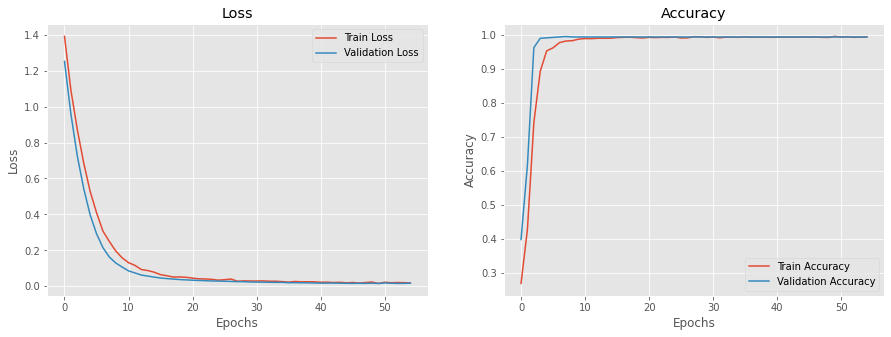

In [16]:
show_final_history(training_history)

In [17]:
#Now use the trained model for prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

29/29 [==============================] - 1s 3ms/step


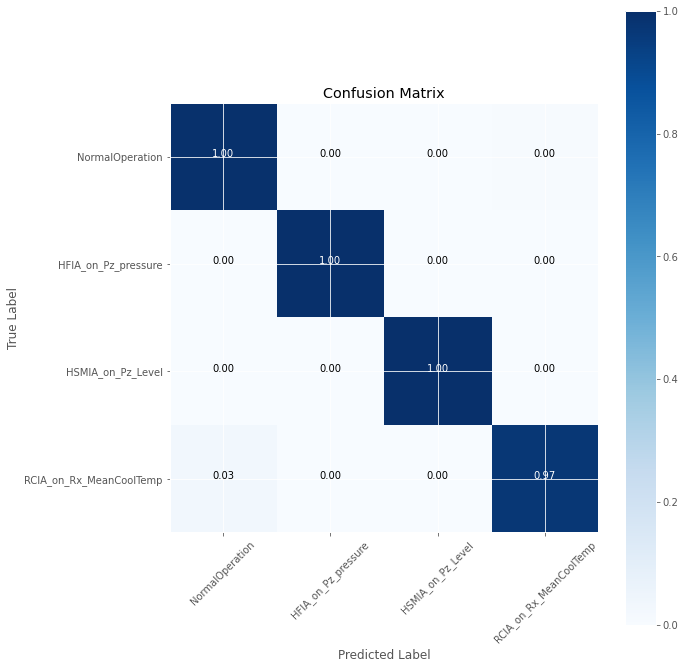

In [18]:
#plot the confusion matrix
y_test = np.argmax(y_test,axis=1)
cnf_mat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cnf_mat,classes=class_names)


In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       225
           1       1.00      1.00      1.00       227
           2       1.00      1.00      1.00       218
           3       1.00      0.97      0.98       231

    accuracy                           0.99       901
   macro avg       0.99      0.99      0.99       901
weighted avg       0.99      0.99      0.99       901



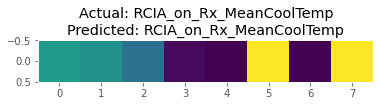

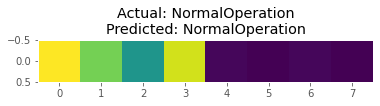

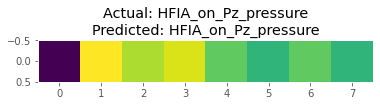

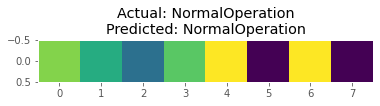

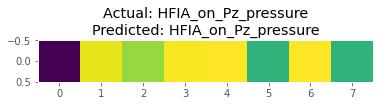

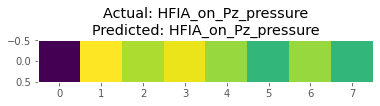

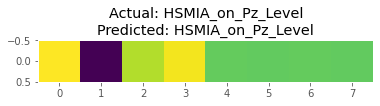

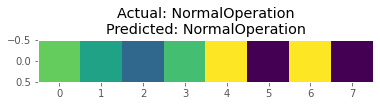

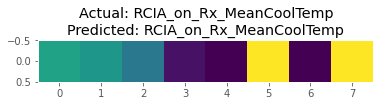

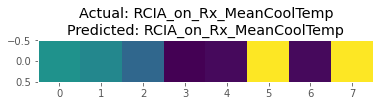

In [20]:
#Another view of the prediction output
rnd_idx = random.sample(range(0,40),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(X_test[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[y_test[idx]],class_labels[y_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass